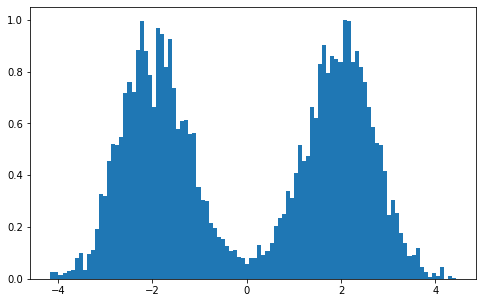

In [1]:
import numpy as np
import matplotlib.pyplot as plt

csv_path = "./CSV/"
plt.rcParams['figure.figsize'] = [8, 5]

data = np.loadtxt(csv_path + "Ex8_sample_test.csv", delimiter=',')

counts, bins = np.histogram(data, 100)
counts = counts / np.max(counts)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

plt.hist(bins[:-1], bins, weights=counts)
plt.show()

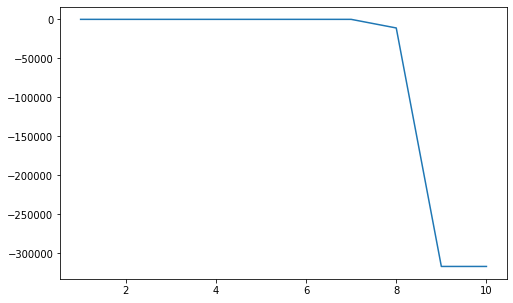

In [4]:
E_data = np.loadtxt(csv_path + "Ex8_E.csv", delimiter=',')

plt.plot(E_data[:,0], E_data[:,1])
plt.show()

In [ ]:
E_final = np.loadtxt(csv_path + "E_final.csv", delimiter=',')

plt.plot(E_final)
plt.show()

Ground state energy:  -0.4604658796927155


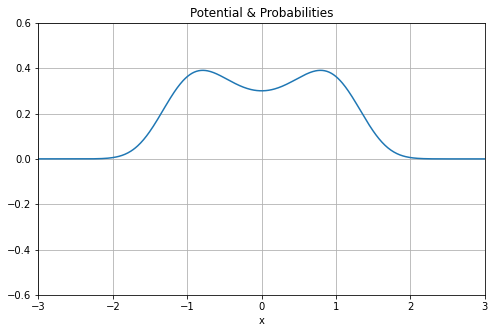

In [3]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 

x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] 
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

E,psi = np.linalg.eigh(H)

psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])

scale = 0.3
plt.plot(x,(psi[0])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()